# Bounds for BVAP Optimization

We compute ordered bounds for the values of VAP, BVAP, and the ratio BVAP/VAP in each district.   For each of these quantities, we separately assume that the quantity value is ordered in the sequence of the districts.   

We then will bring all these bounds together in the end to create bounds on the actual BVAP optimization.
Note: In solution to BVAP optimizaiton, we cannot assume that all of these quantities are ordered simultaneously with the districts.  Instead, we will fix the ordering of the ratio and add cutting planes derived from the bounds on VAP and BVAP.
The two bounds from BVAP and VAP will be added directly to the original model, and then subsequent bounds will be added via callbacks.

In these models below, we work with the non-spatial model of the redistricting.  In a subsequent notebook, we solve for the bounds using spatial models (enforcing contiguity constraints).  In the relaxed non-spatial model, we will obtain worse bounds, but we hope that they are still effective.  We will compare these two versions later.


In [1]:
import gurobipy as gp
from gurobipy import GRB
import sys
import pandas as pd

import numpy as np
import json
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

import json
#File I/O Open function for read data from JSON File
with open('states_data_2020.json') as file_object:
        # store file data in object
        states = json.load(file_object)
        


In [2]:
states

{'AL': {'reps': 7, 'fips': 1, 'name': 'ALABAMA'},
 'AK': {'reps': 1, 'fips': 2, 'name': 'ALASKA'},
 'AZ': {'reps': 9, 'fips': 4, 'name': 'ARIZONA'},
 'AR': {'reps': 4, 'fips': 5, 'name': 'ARKANSAS'},
 'CA': {'reps': 53, 'fips': 6, 'name': 'CALIFORNIA'},
 'CO': {'reps': 7, 'fips': 8, 'name': 'COLORADO'},
 'CT': {'reps': 5, 'fips': 9, 'name': 'CONNECTICUT'},
 'DE': {'reps': 1, 'fips': 10, 'name': 'DELAWARE'},
 'FL': {'reps': 27, 'fips': 12, 'name': 'FLORIDA'},
 'GA': {'reps': 14, 'fips': 13, 'name': 'GEORGIA'},
 'HI': {'reps': 2, 'fips': 15, 'name': 'HAWAII'},
 'ID': {'reps': 2, 'fips': 16, 'name': 'IDAHO'},
 'IL': {'reps': 18, 'fips': 17, 'name': 'ILLINOIS'},
 'IN': {'reps': 9, 'fips': 18, 'name': 'INDIANA'},
 'IA': {'reps': 4, 'fips': 19, 'name': 'IOWA'},
 'KS': {'reps': 4, 'fips': 20, 'name': 'KANSAS'},
 'KY': {'reps': 6, 'fips': 21, 'name': 'KENTUCKY'},
 'LA': {'reps': 6, 'fips': 22, 'name': 'LOUISIANA'},
 'ME': {'reps': 2, 'fips': 23, 'name': 'MAINE'},
 'MD': {'reps': 8, 'fips': 24,

# VAP and BVAP Bounds

In [98]:
def compute_bound(POP,POP_AVG, BVAP, VAP, V,num_districts,n,variable, sense,t = 0.02):
    ''' 
    Modified SHIR model to create bounds for the voting age population or voting age population.
    Objective optimizes a particular district's vap while maintaining ordering of vap or bvap between the districts
    Model is a non-spatial model (i.e., contiguity is not enforced)
    
    POP: Column of population values
    BVAP: Column of black voting age population values
    VAP: Column of voting age population values
    V: Set of districts
    num_districts: number of districts to divide the state into
    n: district number for which we want to obtain a bound on
    t: population deviation allowance
    variable: variable to order and find bounds on.  Should be 'vap' or 'bvap'
    sense: 'upper' or 'lower'
    '''
    #Setup Data
    D = range(num_districts) # set of districts
    #POP_AVG = sum(POP)/num_districts # target population
    
    # Create the model
    m = gp.Model("variable_bounds")
    m.Params.MIPGap = gap
    #m.Params.TimeLimit = maxtime

    #Variables
    x = {i : {k : m.addVar(vtype = GRB.BINARY)  for k in D}  for i in V}
    pop = m.addVars(D, name = 'pop')
    bvap = m.addVars(D, name = 'bvap')
    vap = m.addVars(D, name = 'vap')
    
    if variable == 'vap':
        var = vap
    if variable == 'bvap':
        var = bvap

    
    if sense == 'lower':
        #Objective
        m.setObjective( var[n], GRB.MINIMIZE )
         #Ordering Constraints (only needs to be applied to first n)
        m.addConstrs(   var[k+1]  >=  var[k]             for k in range(num_districts-1)     ) # Ordering constraint 
        
    elif sense == 'upper':
        #Objective
        m.setObjective( var[n], GRB.MAXIMIZE )
        #Ordering Constraints (only needs to be applied to first n)
        m.addConstrs(   var[k+1]  >=  var[k]             for k in range(num_districts-1)     ) # Ordering constraint 
    else:
        print("Required to choose a sense as either lower or upper")
        sys.exit()
    
   

    #SHIR Constraints
    m.addConstrs(   pop[k]    >=  (1-t)*POP_AVG           for k in D     ) # Population
    m.addConstrs(   pop[k]    <=  (1+t)*POP_AVG           for k in D     ) # Population
    m.addConstrs(   sum(x[i][k]  for k in D)   ==  1      for i in V     ) # Assign to exactly 1 district

    m.addConstrs(   sum(BVAP[i]*x[i][k]    for i in V)                ==  bvap[k] for k in D  )
    m.addConstrs(   sum(VAP[i]*x[i][k]    for i in V)                 ==  vap[k] for k in D  )
    m.addConstrs(   sum(POP[i]*x[i][k]    for i in V)                 ==  pop[k] for k in D  )

    #Compile and solve
    m.update()
    #print("\n **Model Compiled** \n")
    m.optimize()
    return m.ObjBound


def compute_vap_bounds_parallel(state, num_districts, t, demographics_file, spatial_network_file,variable, index_col = 'GEOID', gap=0.03,n_jobs=30):
    '''
    Computes lower and upper vap bounds using parallelization.  
    Setting n_jobs = 30 seems to work well on a computer with 48 cores.
    
    '''
    # Load Data
    state = state.lower()
    data = pd.read_csv(demographics_file, index_col = index_col)
    POP = data['POP']
    BVAP = data['BVAP']
    VAP = data['VAP']
    POP_AVG = sum(POP)/num_districts


    ##Generate refference dictionaries.
    G = nx.readwrite.json_graph.adjacency_graph(json.load(open(spatial_network_file % data,'r')))
    V = G.nodes
    #E = G.edges
    
    lower_bd = Parallel(n_jobs=n_jobs)(delayed(compute_bound)(POP, POP_AVG,BVAP, VAP, V,num_districts,n,variable,'lower') for n in range(num_districts))
    upper_bd = Parallel(n_jobs=n_jobs)(delayed(compute_bound)(POP, POP_AVG,BVAP, VAP, V,num_districts,n,variable,'upper') for n in range(num_districts))
    
    
    bounds = {f'{variable.upper()}_lower_bd': lower_bd, f'{variable.upper()}_upper_bd':upper_bd}
    
    # Save the outcomes
    tf = open(f'bounds/{state}_{variable.upper()}_bounds.json', "w")
    json.dump(bounds,tf)
    tf.close()
    
    # Plot the solution
    if variable == 'vap':
        bounds_plot('VAP', state,bounds,sum(VAP)/num_districts,num_districts)
    if variable == 'bvap':
        bounds_plot('BVAP', state,bounds,sum(BVAP)/num_districts,num_districts)
    
    return bounds


def ratio_bounds(POP, POP_AVG,BVAP, VAP, V,num_districts,n,sense):
    ''' 
    Solves a nonconvex MIQCP to establish the bound on bvap/vap for the nth district
    
    Modified SHIR model.
    Objective optimizes a ratio r that is 
    Model is a non-spatial model (i.e., contiguity is not enforced)
    
    POP: Column of population values
    BVAP: Column of black voting age population values
    VAP: Column of voting age population values
    V: Set of districts
    num_districts: number of districts to divide the state into
    n: district number for which we want to obtain a bound on
    t: population deviation allowance
    variable: variable to order and find bounds on.  Should be 'vap' or 'bvap'
    sense: 'upper' or 'lower'
    
    Note 1: Assuming an ordering on districts, we do not have a model that computes bounds on different districts simultaneously.
    Hence, these bounds are computed sequentially.   This is why you must pass the argument 'bounds' to this function.
    
    Note 2: The objective variable r represent the ratio bound.  It turns out that Gurobi solves this faster if it is
    created as a discrete variable.  This is likely due to the branching capabilities are better for discrete variables than 
    for continuous variables (i.e., their integer programming branching is more established than their spatial branch and bound schemes).
    
    Note 3: Typical precision for Gurobi is 10^-6.   We bumped the precision up to 10^-9 to get more detailed bounds.
    Because of numerical prevision issues, to get a true bound in the end, 
    we return the m.ObjBound +/- 10^-9  where +/- depends on finding upper or lower bounds.

    '''
    if sense =='lower':
        print("Ratio Lower Bounds - Bound for district: ", n)
    if sense =='upper':
        print("Ratio Upper Bounds - Bound for district: ", n)
        
    D = range(num_districts)

    m = gp.Model("ratio_bounds")
    m.setParam('NonConvex', 2)
    m.Params.MIPGap = 0.0001  
    m.setParam('OptimalityTol', 10**-9)
    m.setParam('FeasibilityTol', 10**-9)
    
    m.Params.OutputFlag = 0
    m.Params.TimeLimit = 400

    #Variables
    x = {i : {k : m.addVar(vtype = GRB.BINARY)  for k in D}  for i in V}
    pop = m.addVars(D, name = 'pop')
    bvap = m.addVars(D, name = 'bvap')
    vap = m.addVars(D, name = 'vap')
    
    R = m.addVar(vtype = GRB.INTEGER, lb = 0, ub = 10**9, name = 'R')
    m.setAttr("BranchPriority", R, 10)
    
    if sense == 'lower':
        #Objective
        m.setObjective( R, GRB.MINIMIZE )
        m.addConstrs(   10**9*bvap[k]  <=  vap[k]*R         for k in range(n)     ) # r_guess
        #m.addConstrs(   bvap[k]  <=  vap[k]*(0.007263003-10**-9)         for k in range(n)     ) # r_guess

        #print("Length of bounds ", len(bounds))
        #for k in range(len(bounds)):
            #print("k:", k)
            #m.addConstrs(   bvap[j]  >=  vap[j]*bounds[k] for j in range(k,num_districts) ) # prior computed bounds apply to all subsequent districts
    
    if sense == 'upper':
        #Objective
        m.setObjective( R, GRB.MAXIMIZE )
        

        m.addConstr(  R <= 10**9*max(BVAP/VAP))
        
        m.addConstrs(   10**9*bvap[k]  >=  vap[k]*R         for k in range(num_districts - n+1)     ) # r_guess
        #m.addConstrs(   bvap[k]  <=  vap[k]*(0.007263003-10**-9)         for k in range(n)     ) # r_guess

        #print("Length of bounds ", len(bounds))
        #for k in range(len(bounds)):
            #print("k:", k)
            #m.addConstrs(   bvap[j]  <=  vap[j]*bounds[k] for j in range(k,num_districts) ) # prior computed bounds apply to all subsequent districts

    #Constraints
    m.addConstrs(   pop[k]    >=  (1-t)*POP_AVG           for k in D     ) # Population
    m.addConstrs(   pop[k]    <=  (1+t)*POP_AVG           for k in D     ) # Population
    m.addConstrs(   sum(x[i][k]  for k in D)   ==  1      for i in V     ) # Assign to exactly 1 district

    m.addConstrs(   sum(BVAP[i]*x[i][k]    for i in V)                ==  bvap[k] for k in D  )
    m.addConstrs(   sum(VAP[i]*x[i][k]    for i in V)                 ==  vap[k] for k in D  )
    m.addConstrs(   sum(POP[i]*x[i][k]    for i in V)                 ==  pop[k] for k in D  )

    #Compile and solve
    m.update()
    #print("\n **Model Compiled** \n")
    m.optimize()
    
     # info on model status: https://www.gurobi.com/documentation/9.1/refman/optimization_status_codes.html#sec:StatusCodes
#     if m.Status == 3 or m.Status == 4: #3 means infeasible, 4 means infeasile or unbounded
#         Infeasible = True
#         rvalue = 0
#     else:
#         Infeasible = False
    print("Sol value: ", bvap[n-1].x/vap[n-1].x)
    Gap=max(0, abs(m.ObjVal-m.ObjBound)/abs(m.ObjVal))
    if sense == 'lower':
        error = -1/10**9
    if sense == 'upper':
        error = 1/10**9
    return m.ObjBound/10**9 + error, Gap


# def ratio_bounds_list(POP, POP_AVG,BVAP, VAP, V,num_districts,sense):

#     if sense == 'lower':
#         bounds = []
#         bounds_gap = []
#         for n in range(1,num_districts+1):
#             Infeasible, r, bd_gap = ratio_bounds(POP, BVAP, VAP, POP_AVG, V,num_districts,n,bounds,sense)
#             print("r: ", r)
#             bounds = bounds + [r-10**-9]
#             bounds_gap = bounds_gap + [bd_gap]
#             print("Lower bounds: ", bounds, "  Gaps: ",bounds_gap )
#         return bounds
    
#     if sense == 'upper':
#         bounds = []
#         bounds_gap = []
#         for n in range(1,num_districts+1):
#             Infeasible, r, bd_gap = ratio_bounds(POP, BVAP, VAP, POP_AVG, V,num_districts,n,bounds,sense)
#             print("r: ", r)
#             bounds = bounds + [r+10**-9]
#             bounds_gap = bounds_gap + [bd_gap]
#             print("Upper bounds: ", bounds, "  Gaps: ",bounds_gap )
#         return boundsarr[::-1]
    
#     # If reach this point, the sense was given incorrectly
#     print("sense needs to be either upper or lower")
#     return 0

# def compute_ratio_bounds_parallel(state, num_districts, t, demographics_file, spatial_network_file, index_col = 'GEOID', gap=0.03,n_jobs=30):
#     '''
#     Computes lower and upper vap bounds using parallelization.  
#     Setting n_jobs = 30 seems to work well on a computer with 48 cores.
    
#     '''
#     # Load Data
#     state = state.lower()
#     data = pd.read_csv(demographics_file, index_col = index_col)
#     POP = data['POP']
#     BVAP = data['BVAP']
#     VAP = data['VAP']
#     POP_AVG = sum(POP)/num_districts


#     ##Generate refference dictionaries.
#     G = nx.readwrite.json_graph.adjacency_graph(json.load(open(spatial_network_file % data,'r')))
#     V = G.nodes
#     #E = G.edges
    
#     lower_bd,upper_bd = Parallel(n_jobs=n_jobs)(delayed
#                         (ratio_bounds_list)(POP, POP_AVG,BVAP, VAP, V,num_districts,sense) 
#                                                 for sense in ['lower', 'upper'])
    
#     bounds = {f'RATIO_lower_bd': lower_bd, f'RATIO_upper_bd':upper_bd}
    
#     # Save the outcomes
#     tf = open(f'bounds/{state}_RATIO_bounds.json', "w")
#     json.dump(bounds,tf)
#     tf.close()
    
#     # Plot the solution
#     bounds_plot('RATIO', state,bounds,sum(BVAP)/sum(VAP),num_districts)
    
#     return bounds


def compute_ratio_bounds_parallel_new(state, num_districts, t, demographics_file, spatial_network_file, index_col = 'GEOID', gap=0.03,n_jobs=30):
    '''
    Computes lower and upper vap bounds using parallelization.  
    Setting n_jobs = 30 seems to work well on a computer with 48 cores.
    
    '''
    # Load Data
    state = state.lower()
    data = pd.read_csv(demographics_file, index_col = index_col)
    POP = data['POP']
    BVAP = data['BVAP']
    VAP = data['VAP']
    POP_AVG = sum(POP)/num_districts


    ##Generate refference dictionaries.
    G = nx.readwrite.json_graph.adjacency_graph(json.load(open(spatial_network_file % data,'r')))
    V = G.nodes
    #E = G.edges
    
    lower_bd_and_gap = Parallel(n_jobs=n_jobs)(delayed(ratio_bounds)(POP, POP_AVG,BVAP, VAP, V,num_districts,n,'lower') for n in range(1,num_districts+1))
    upper_bd_and_gap = Parallel(n_jobs=n_jobs)(delayed(ratio_bounds)(POP, POP_AVG,BVAP, VAP, V,num_districts,n,'upper') for n in range(1,num_districts+1))

    lower_bd = [item[0] for item in lower_bd_and_gap]
    lower_bd_gap = [item[1] for item in lower_bd_and_gap]
    upper_bd = [item[0] for item in upper_bd_and_gap]
    upper_bd_gap = [item[1] for item in upper_bd_and_gap]
    bounds = {'RATIO_lower_bd': lower_bd, 'RATIO_upper_bd':upper_bd,'lower_bd_gap':lower_bd_gap,'upper_bd_gap':upper_bd_gap  }
    
    # Save the outcomes
    tf = open(f'bounds/{state}_RATIO_bounds.json', "w")
    json.dump(bounds,tf)
    tf.close()
    
    # Plot the solution
    bounds_plot('RATIO', state,bounds,sum(BVAP)/sum(VAP),num_districts)
    
    return bounds

# Plotting function

In [78]:
def bounds_plot(quantity,state,bounds,avg,d):
    '''Makes a pretty plot showing how the bounds turn out'''
    lower_bd,upper_bd = bounds[f'{quantity}_lower_bd'], bounds[f'{quantity}_upper_bd']
    plt.scatter([i+1 for i in range(d)],lower_bd, label = f'{quantity} Lower bound')
    plt.scatter([i+1 for i in range(d)],upper_bd, label = f'{quantity} Upper bound')
    plt.plot([1,d],[avg,avg], '--', color = 'green', label= f'Average {quantity}')
    col = 'name'
    plt.title(f'Bounds for {quantity} in {states[state.upper()][col]}\n (without using contiguity)')
    plt.xlabel('District Number')
    plt.ylabel(quantity)
    plt.legend()
    plt.savefig(f'bounds/{state}_{quantity}_bounds_plot.jpg', format='jpg')
    plt.show()

## Computing the bounds

AL


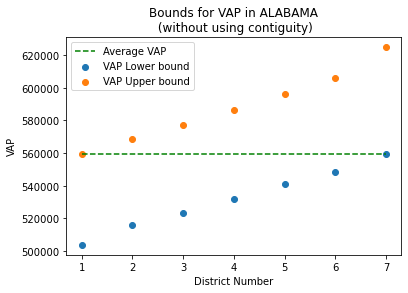

Time of computation:  6.284382200001346


In [99]:
import time

t = 0.2
gap = 0.01

for stateCAP in ['AL']: #states.keys():
    print(stateCAP)
    tic = time.perf_counter()
    state = stateCAP.lower()
    num_districts = states[state.upper()]['reps']
    if num_districts < 15:
        demographics_file = f'data2020/demographics/t/{state}_t_demographics_2020.csv'
        spatial_network_file = f'data2020/spatial_network/t/{state}_pl2020_t.json'
        vap_bounds = compute_vap_bounds_parallel(state, num_districts, t, demographics_file, spatial_network_file,'vap')
        #bvap_bounds = compute_vap_bounds_parallel(state, num_districts, t, demographics_file, spatial_network_file,'bvap')
        #ratio_bounds = compute_ratio_bounds_parallel_new(state, num_districts, t, demographics_file, spatial_network_file)
    else:
        print("Skipping this state due to too many districts")

    toc = time.perf_counter()
    print("Time of computation: ", toc-tic)

In [76]:
ratio_bounds

{'RATIO_lower_bd': [0.007263001999999999,
  0.02069459,
  0.036862406029743215,
  0.061319780909962346,
  0.09805474760752385,
  0.15126421630789588,
  0.2505815206167492],
 'RATIO_upper_bd': [0.2506832410272059,
  0.3002363704505301,
  0.3623240669806402,
  0.4452124382207025,
  0.5436655493043626,
  0.659653128759551,
  0.8174225802333157]}

In [80]:
ratio_bounds

{'RATIO_lower_bd': [0.007263001999999999,
  0.02069459,
  0.03686240602979872,
  0.061319780909962346,
  0.09805579283215203,
  0.15126421630789588,
  0.25058152061674926],
 'RATIO_upper_bd': [0.25068324102720585,
  0.3002363704505301,
  0.3623229703400511,
  0.4451828866719399,
  0.543270053382328,
  0.659653128759551,
  0.8174225802333157],
 'lower_bd_gap': [0,
  0.00014977516091046098,
  0.00029837138739419763,
  0.0007933242008090468,
  0.00037849996810143026,
  0.0004982217683682206,
  0.00026949385150606525],
 'upper_bd_gap': [0.00037450518588320636,
  0.000556842911889341,
  0.00039812752597936484,
  0.00043730740055464664,
  0.0002509573057814779,
  8.550491091190519e-05,
  7.090744051766196e-05]}

# Example Knapsack for sanity check

In [90]:
stateCAP = 'AL' #states.keys():
print(stateCAP)
tic = time.perf_counter()
state = stateCAP.lower()
num_districts = states[state.upper()]['reps']
if num_districts < 15:
    demographics_file = f'data2020/demographics/t/{state}_t_demographics_2020.csv'
    spatial_network_file = f'data2020/spatial_network/t/{state}_pl2020_t.json'

# Load Data
state = state.lower()
data = pd.read_csv(demographics_file, index_col = 'GEOID')
POP = data['POP']
BVAP = data['BVAP']
VAP = data['VAP']
POP_AVG = sum(POP)/num_districts
VAP_TOTAL = sum(VAP)
BVAP_TOTAL = sum(VAP)

G = nx.readwrite.json_graph.adjacency_graph(json.load(open(spatial_network_file % data,'r')))
V = G.nodes

AL


In [48]:
max(BVAP/VAP)

0.9826937547027841

In [49]:
min(BVAP/VAP)

0.0

In [68]:
D = range(num_districts)

m = gp.Model("knapsack")
m.Params.MIPGap = 0.0001  


#Variables
x = {i : m.addVar(vtype = GRB.BINARY)   for i in V}

m.setObjective( sum(x[i]*BVAP[i]/max(VAP[i],1) for i in V), GRB.MINIMIZE )
m.addConstr(sum(POP[i]*x[i] for i in V) >= POP_AVG)
m.optimize()

Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads
Optimize a model with 1 rows, 1437 columns and 1434 nonzeros
Model fingerprint: 0x22e8debb
Variable types: 0 continuous, 1437 integer (1437 binary)
Coefficient statistics:
  Matrix range     [2e+00, 1e+04]
  Objective range  [4e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+05, 7e+05]
Found heuristic solution: objective 70.6654215
Presolve removed 0 rows and 12 columns
Presolve time: 0.01s
Presolved: 1 rows, 1425 columns, 1425 nonzeros
Variable types: 0 continuous, 1425 integer (1425 binary)

Root relaxation: objective 1.755985e+00, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.75598    0    1   70.66542 

In [69]:
sum(BVAP[i]*x[i].x for i in V)/sum(VAP[i]*x[i].x for i in V)

0.011414127309767529

In [65]:
sum(BVAP[i]*x[i].x for i in V)

0.0

# Load Bounds


In [100]:
import json
#File I/O Open function for read data from JSON File
def load_json(file):
    with open(file) as file_object:
            # store file data in object
            data = json.load(file_object)
    return data

bvap_bounds = load_json('bounds/al_BVAP_bounds.json')
vap_bounds = load_json('bounds/al_VAP_bounds.json')
RATIO_bounds = load_json('bounds/al_RATIO_bounds.json')


In [85]:
import scipy.stats as stats
t = .05 # deviation from average population
gap = .05  # acceptable optimality gap
maxtime = 12*60*60


#Cdf function
def cdf_fun(x):
    if x < 0.07:
        return 0
    return stats.norm.cdf(8.26*x-3.271)


#RATIO_BREAKPOINTS = [i/PWL_PARTS  for i in range(PWL_PARTS+1)]
# the below ratio breakpoints were computed in Mathematica for some reason.
RATIO_BREAKPOINTS = [0.158721, 0.19687, 0.221727, 0.240853, 0.256737, 0.270529, 0.282858, 0.294114, 0.30455, 0.314347, 0.323637, 0.332518, 0.34107, 0.349356, 0.357429, 0.365333, 0.373109, 0.380792, 0.388413, 0.396005, 0.403596,  0.411218, 0.418901, 0.426676, 0.434581, 0.442654, 0.45094, 0.459492,  0.468373, 0.477662, 0.487459, 0.497896, 0.509151, 0.521481, 0.535272,  0.551156, 0.570282, 0.59514, 0.633289, 1]
PWL_PARTS = len(RATIO_BREAKPOINTS)-1
CDF_VALUES = [cdf_fun(r)  for r in RATIO_BREAKPOINTS] # function values at breakpoints

In [124]:
m = gp.Model("ratio_optimization")

m.Params.MIPGap = 0.0001  
#m.setParam('OptimalityTol', 10**-9)
# m.setParam('FeasibilityTol', 10**-9)

#m.Params.OutputFlag = 0
m.Params.TimeLimit = 400

#Variables
#pop = m.addVars(D, name = 'pop')
bvap = m.addVars(D, name = 'bvap')
vap = m.addVars(D, name = 'vap')

## variables for modeling the objective function
cdf = {k : m.addVar(lb = 0, ub = 1, name = f"cdf{k}")   for k in D} # r = cdf(8.26 q - 3.271)
delta = {k : {l : m.addVar(vtype = GRB.BINARY)  for l in range(PWL_PARTS+1)}  for k in D}

#Objective
m.setObjective( sum(cdf[j] for j in range(num_districts)), GRB.MAXIMIZE)


m.addConstrs(   bvap[k]  <=  vap[k]*RATIO_bounds['RATIO_upper_bd'][k]         for k in D     ) 
m.addConstrs(   bvap[k]  >=  vap[k]*RATIO_bounds['RATIO_lower_bd'][k]         for k in D    ) 

m.addConstrs(   bvap[k]  >=  bvap_bounds['BVAP_lower_bd'][0]         for k in D    ) 
m.addConstrs(   bvap[k]  <=  bvap_bounds['BVAP_upper_bd'][num_districts-1]          for k in D    ) 

m.addConstrs(   vap[k]  >=  vap_bounds['VAP_lower_bd'][0]         for k in D    ) 
m.addConstrs(   vap[k]  <=  vap_bounds['VAP_upper_bd'][num_districts-1]          for k in D    ) 



m.addConstrs(   sum(bvap[k] for k in combo)  >=  sum(bvap_bounds['BVAP_lower_bd'][k] for k in range(len(combo)))    for    combo in combos    ) 
m.addConstrs(   sum(bvap[k] for k in combo)  <=  sum((bvap_bounds['BVAP_upper_bd'][::-1])[k] for k in range(len(combo)))  for      combo in combos    ) 

m.addConstrs(   sum(vap[k] for k in combo)  >=  sum(vap_bounds['VAP_lower_bd'][k] for k in range(len(combo)))   for     combo in combos    ) 
m.addConstrs(   sum(vap[k] for k in combo)  <=  sum((vap_bounds['VAP_upper_bd'][::-1])[k] for k in range(len(combo)))     for   combo in combos    ) 


#Constraints
#     m.addConstrs(   pop[k]    >=  (1-t)*POP_AVG           for k in D     ) # Population
#     m.addConstrs(   pop[k]    <=  (1+t)*POP_AVG           for k in D     ) # Population


#     m.addConstr(   sum(pop[k] for k in D)   ==  sum(POP)    ) # Population
m.addConstr(   sum(bvap[k] for k in D)   ==  sum(BVAP)    ) # Population
m.addConstr(   sum(vap[k] for k in D)   ==  sum(VAP)    ) # Population


#     m.addConstrs(   sum(x[i][k]  for k in D)   ==  1      for i in V     ) # Assign to exactly 1 district

#     m.addConstrs(   sum(BVAP[i]*x[i][k]    for i in V)                ==  bvap[k] for k in D  )
#     m.addConstrs(   sum(VAP[i]*x[i][k]    for i in V)                 ==  vap[k] for k in D  )
#     m.addConstrs(   sum(POP[i]*x[i][k]    for i in V)                 ==  pop[k] for k in D  )



## Decide value of cdf[j]
## We focus on the fact that the cdf is an increasing function
## We model  "if ratio <= RATIO_BREAKPOINT, then cdf <= CDF_VALUE@RATIO_BREAKPOINT"
## For this, we use an indicator variable \delta, where \delta = 1 means ratio <= RATIO_BREAKPOINT

### if bvap/vap <= ratio, then delta = 1
### --->  if bvap - ratio*vap <= 0, then delta = 1
### --->  if ratio*vap - bvap > 0, then delta = 1
### --->  ratio*vap - bvap <= M*delta
m.addConstrs(( RATIO_BREAKPOINTS[l]*vap[j] - bvap[j] <=  VAP_TOTAL*delta[j][l] for j in D  for l in range(PWL_PARTS+1)  ), name="breakpoint_bound")

### if delta = 1, then cdf_j <= CDF_VALUE: (note: 1 acts as the big M here)
m.addConstrs(( cdf[j] <= CDF_VALUES[l] + (1-delta[j][l])   for j in D  for l in range(PWL_PARTS+1)  ), name="cdf_bound")

### delta variables are ordered (i.e., if ratio[j] <= RATIO_BREAKPOINT[l], then ratio[j] <= RATIO_BREAKPOINT[l+1])
### thus, if \delta[l] = 1, then \delta[l+1] = 1
m.addConstrs(( delta[j][l] <= delta[j][l+1]  for j in D  for l in range(PWL_PARTS)  ), name="cdf_bound")



#Compile and solve
m.update()
#print("\n **Model Compiled** \n")
m.optimize()

Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 400.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 24 physical cores, 48 logical processors, using up to 24 threads
Optimize a model with 1385 rows, 301 columns and 3808 nonzeros
Model fingerprint: 0x543a4a2f
Variable types: 21 continuous, 280 integer (280 binary)
Coefficient statistics:
  Matrix range     [7e-03, 4e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+06]
Presolve removed 659 rows and 116 columns
Presolve time: 0.02s
Presolved: 726 rows, 185 columns, 2239 nonzeros
Variable types: 21 continuous, 164 integer (164 binary)
Found heuristic solution: objective 0.3999994

Root relaxation: objective 3.913113e+00, 755 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

In [125]:
print([cdf[k].x for k in D])

[0.024999967536122325, 0.024999967536122304, 0.024999967536122263, 0.024999967536122294, 0.8999994725309205, 1.0, 0.9750001844205065]


In [126]:
print([bvap[k].x/vap[k].x for k in D])

[0.007263001999999809, 0.02069459, 0.036862406029798726, 0.06346112727314715, 0.535272, 0.633289, 0.59514]


In [120]:
print([bvap[k].x/vap[k].x<= RATIO_bounds['RATIO_upper_bd'][k] for k in D])

[True, True, True, True, True, True, True]


In [122]:
print([bvap[k].x/vap[k].x>= RATIO_bounds['RATIO_lower_bd'][k]-10**(-7) for k in D])

[True, True, True, True, True, True, True]


In [130]:
bvaps = [bvap[k].x for k in D]
bvaps.sort()
print(bvaps)

[4538.250484689881, 12343.101954189999, 20146.594994718038, 38475.39879209449, 280187.593128, 306979.79586830764, 319052.264778]


In [134]:
[bvaps[k] <= bvap_bounds['BVAP_upper_bd'][k] for k in D]

[True, True, True, True, True, True, True]

In [135]:
[bvaps[k] >= bvap_bounds['BVAP_lower_bd'][k] for k in D]

[True, True, True, True, True, True, True]

In [136]:
vaps = [vap[k].x for k in D]
vaps.sort()
print(vaps)

[503802.0, 515811.0627218934, 523449.0, 546534.9977001499, 596441.0, 606282.9395779567, 624845.0]


In [142]:
[vaps[k] <= vap_bounds['VAP_upper_bd'][k] for k in D]

[True, True, True, True, True, False, True]

In [145]:
[vaps[k] >= vap_bounds['VAP_lower_bd'][k]-1 for k in D]

[True, True, True, True, True, True, True]

In [119]:
RATIO_bounds

{'RATIO_lower_bd': [0.007263001999999999,
  0.02069459,
  0.03686240602979872,
  0.061319780909962346,
  0.09805579283215203,
  0.15126421630789588,
  0.25058152061674926],
 'RATIO_upper_bd': [0.25068324102720585,
  0.3002363704505301,
  0.3623229703400511,
  0.4451828866719399,
  0.543270053382328,
  0.659653128759551,
  0.8174225802333157],
 'lower_bd_gap': [0,
  0.00014977516091046098,
  0.00029837138739419763,
  0.0007933242008090468,
  0.00037849996810143026,
  0.0004982217683682206,
  0.00026949385150606525],
 'upper_bd_gap': [0.00037450518588320636,
  0.000556842911889341,
  0.00039812752597936484,
  0.00043730740055464664,
  0.0002509573057814779,
  8.550491091190519e-05,
  7.090744051766196e-05]}

In [101]:
vap_bounds

{'VAP_lower_bd': [503802.0,
  515811.0627218935,
  523449.0,
  531961.0,
  540920.0241688174,
  548721.0,
  559596.0],
 'VAP_upper_bd': [559595.0,
  568894.0,
  577108.0,
  586705.0,
  596441.0,
  606282.9395779566,
  624845.0]}

In [102]:
bvap_bounds

{'BVAP_lower_bd': [3247.0,
  9258.0,
  16450.0,
  29085.0,
  50422.0,
  81924.0,
  140247.0],
 'BVAP_upper_bd': [140246.0,
  163079.0,
  192641.0,
  233093.0,
  288462.0,
  364806.7023705004,
  490188.55936920224]}

In [106]:
2**7

128

In [115]:
from itertools import combinations
s = range(7)
combos = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

In [114]:
q

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 4, 5),
 (0, 4, 6),
 (0, 5, 6),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (1, 5, 6),
 (2, 3, 4),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 5),
 (2, 4, 6),
 (2, 5, 6),
 (3, 4, 5),
 (3, 4, 6),
 (3, 5, 6),
 (4, 5, 6),
 (0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 2, 5),
 (0, 1, 2, 6),
 (0, 1, 3, 4),
 (0, 1, 3, 5),
 (0, 1, 3, 6),
 (0, 1, 4, 5),
 (0, 1, 4, 6),
 (0, 1, 5, 6),
 (0, 2, 3, 4),
 (0, 2, 3, 5),
 (0, 2, 3, 6),
 (0, 2, 4, 5),
 (0, 2, 4, 6),
 (0, 2, 5, 6),
 (0, 3, 4, 5),
 (0, 3, 4, 6),
 (0, 3, 5, 6),
 (0, 4, 5, 6),
 (1, 2, 3, 4),
 (1, 2, 3, 5),
 (1, 2, 3, 6

In [111]:
q[1][0]

2

In [112]:
len(q[1])

1

# Integer Programming Assign Blocks - Non-spatial

In [ ]:
m = gp.Model("ratio_optimization")

m.Params.MIPGap = 0.0001  
#m.setParam('OptimalityTol', 10**-9)
# m.setParam('FeasibilityTol', 10**-9)

#m.Params.OutputFlag = 0
m.Params.TimeLimit = 400

#Variables

#Variables
x = {i : {k : m.addVar(vtype = GRB.BINARY)  for k in D}  for i in V}
    
pop = m.addVars(D, name = 'pop')
bvap = m.addVars(D, name = 'bvap')
vap = m.addVars(D, name = 'vap')

## variables for modeling the objective function
cdf = {k : m.addVar(lb = 0, ub = 1, name = f"cdf{k}")   for k in D} # r = cdf(8.26 q - 3.271)
delta = {k : {l : m.addVar(vtype = GRB.BINARY)  for l in range(PWL_PARTS+1)}  for k in D}

#Objective
m.setObjective( sum(cdf[j] for j in range(num_districts)), GRB.MAXIMIZE)


m.addConstrs(   bvap[k]  <=  vap[k]*RATIO_bounds['RATIO_upper_bd'][k]         for k in D     ) 
m.addConstrs(   bvap[k]  >=  vap[k]*RATIO_bounds['RATIO_lower_bd'][k]         for k in D    ) 

m.addConstrs(   bvap[k]  >=  bvap_bounds['BVAP_lower_bd'][0]         for k in D    ) 
m.addConstrs(   bvap[k]  <=  bvap_bounds['BVAP_upper_bd'][num_districts-1]          for k in D    ) 

m.addConstrs(   vap[k]  >=  vap_bounds['VAP_lower_bd'][0]         for k in D    ) 
m.addConstrs(   vap[k]  <=  vap_bounds['VAP_upper_bd'][num_districts-1]          for k in D    ) 



m.addConstrs(   sum(bvap[k] for k in combo)  >=  sum(bvap_bounds['BVAP_lower_bd'][k] for k in range(len(combo)))    for    combo in combos    ) 
m.addConstrs(   sum(bvap[k] for k in combo)  <=  sum((bvap_bounds['BVAP_upper_bd'][::-1])[k] for k in range(len(combo)))  for      combo in combos    ) 

m.addConstrs(   sum(vap[k] for k in combo)  >=  sum(vap_bounds['VAP_lower_bd'][k] for k in range(len(combo)))   for     combo in combos    ) 
m.addConstrs(   sum(vap[k] for k in combo)  <=  sum((vap_bounds['VAP_upper_bd'][::-1])[k] for k in range(len(combo)))     for   combo in combos    ) 


#Constraints
#     m.addConstrs(   pop[k]    >=  (1-t)*POP_AVG           for k in D     ) # Population
#     m.addConstrs(   pop[k]    <=  (1+t)*POP_AVG           for k in D     ) # Population


#     m.addConstr(   sum(pop[k] for k in D)   ==  sum(POP)    ) # Population
m.addConstr(   sum(bvap[k] for k in D)   ==  sum(BVAP)    ) # Population
m.addConstr(   sum(vap[k] for k in D)   ==  sum(VAP)    ) # Population


#     m.addConstrs(   sum(x[i][k]  for k in D)   ==  1      for i in V     ) # Assign to exactly 1 district

#     m.addConstrs(   sum(BVAP[i]*x[i][k]    for i in V)                ==  bvap[k] for k in D  )
#     m.addConstrs(   sum(VAP[i]*x[i][k]    for i in V)                 ==  vap[k] for k in D  )
#     m.addConstrs(   sum(POP[i]*x[i][k]    for i in V)                 ==  pop[k] for k in D  )



## Decide value of cdf[j]
## We focus on the fact that the cdf is an increasing function
## We model  "if ratio <= RATIO_BREAKPOINT, then cdf <= CDF_VALUE@RATIO_BREAKPOINT"
## For this, we use an indicator variable \delta, where \delta = 1 means ratio <= RATIO_BREAKPOINT

### if bvap/vap <= ratio, then delta = 1
### --->  if bvap - ratio*vap <= 0, then delta = 1
### --->  if ratio*vap - bvap > 0, then delta = 1
### --->  ratio*vap - bvap <= M*delta
m.addConstrs(( RATIO_BREAKPOINTS[l]*vap[j] - bvap[j] <=  VAP_TOTAL*delta[j][l] for j in D  for l in range(PWL_PARTS+1)  ), name="breakpoint_bound")

### if delta = 1, then cdf_j <= CDF_VALUE: (note: 1 acts as the big M here)
m.addConstrs(( cdf[j] <= CDF_VALUES[l] + (1-delta[j][l])   for j in D  for l in range(PWL_PARTS+1)  ), name="cdf_bound")

### delta variables are ordered (i.e., if ratio[j] <= RATIO_BREAKPOINT[l], then ratio[j] <= RATIO_BREAKPOINT[l+1])
### thus, if \delta[l] = 1, then \delta[l+1] = 1
m.addConstrs(( delta[j][l] <= delta[j][l+1]  for j in D  for l in range(PWL_PARTS)  ), name="cdf_bound")




m.addConstrs(   sum(BVAP[i]*x[i][k]    for i in V)                ==  bvap[k] for k in D  )
m.addConstrs(   sum(VAP[i]*x[i][k]    for i in V)                 ==  vap[k] for k in D  )
m.addConstrs(   sum(POP[i]*x[i][k]    for i in V)                 ==  pop[k] for k in D  )

#Compile and solve
m.update()
#print("\n **Model Compiled** \n")
m.optimize()